## Analyzing Iowa Housing Data: Kaggle competition
### (INCOMPLETE)
#### Matthew Johnson, July 15, 2018

### Goal <br> 
- To predict the sales price for each house.<br>

### Metric <br>
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)<br>

#### Steps taken to clean data
- Remove outliers
- Change some numeric data to categorical
- Fill in missing data
- Recode ordinal variables
- Add additional features
- Scale/transform features
- One hot encoding



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fileTrain = '/Users/mattjohnson/Desktop/Python 2018/kaggleHousing/train.csv'
fileTest = '/Users/mattjohnson/Desktop/Python 2018/kaggleHousing/test.csv'

training = pd.read_csv(fileTrain)
testing = pd.read_csv(fileTest)

print('shape of training data: ', training.shape)
print('shape of testing data: ', testing.shape)

shape of training data:  (1460, 81)
shape of testing data:  (1459, 80)


In [3]:
train = training.copy()
test = testing.copy()

# removing outliers
train = train.drop([691, 1182, 457, 769, 178, 803, 898, 1046])

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

sale_price = train['SalePrice']

ntrain = train.shape[0]
print('ntrain:', ntrain)
ntest = test.shape[0]
print('ntest:', ntest)

y_train = train.SalePrice.values
all_data = pd.concat((train, test)) #.reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))


#del all_data['Id']
del all_data['MiscVal']
del all_data['PoolArea']
del all_data['ScreenPorch']
del all_data['3SsnPorch']
del all_data['LowQualFinSF']
del all_data['BsmtFinSF2']

ntrain: 1452
ntest: 1459
all_data size is : (2911, 80)


### Our target value: SalePrice


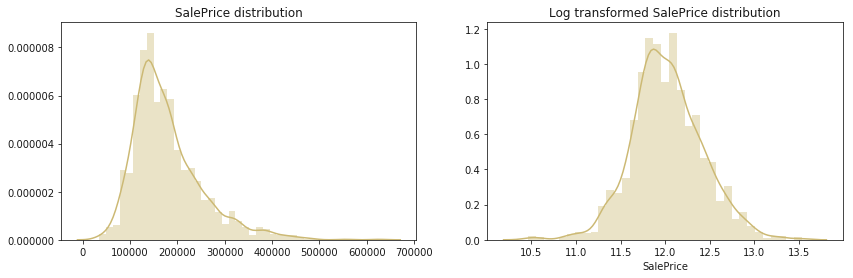

In [4]:
plt.subplots(figsize=(14,4))

sns.set_color_codes()
plt.subplot(1, 2, 1)
ax = sns.distplot(y_train, color="y").set_title('SalePrice distribution');

#log transform
plt.subplot(1, 2, 2)
df_train = training.copy()
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.set_color_codes()
ax = sns.distplot(df_train['SalePrice'], color="y", ).set_title('Log transformed SalePrice distribution');

#### Analyzing and inputting missing data

In [5]:
#missing data - borrowed
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[ missing_data['Total']>0]
missing_data.head()

,Total,Percent
PoolQC,2902,0.996908
MiscFeature,2806,0.963930
Alley,2713,0.931982
Fence,2341,0.804191
FireplaceQu,1420,0.487805


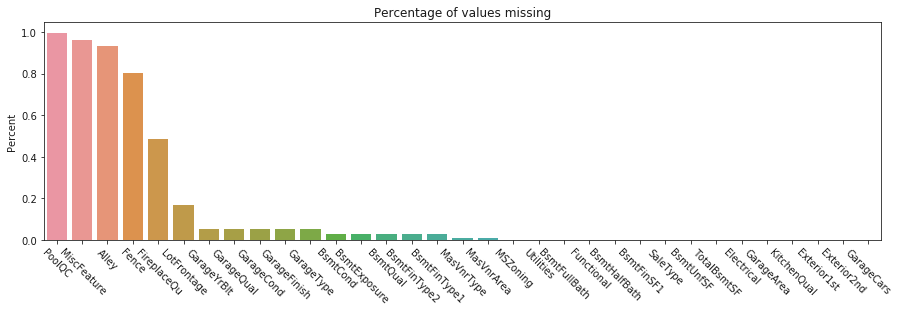

In [6]:
plt.subplots(figsize=(15,4))
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xticks(rotation=-45)
plt.title('Percentage of values missing');

### Ordinal categorical variables: Condition/Quality

Some of the categorical variables had an ordering to them, we will call them qualitative variables. To preserve that I wrote a method that takes each of those qualitative variables and orders them by the 'SalePrice' mean of that subcategory and maps the column to numerical with a dictionary. Higher number implies better. <br>
For example, *'BsmtQual' : {'Ex': 4, 'Fa': 1, 'Gd': 3, 'TA': 2, 'missing': 0}*.

In [7]:
# method for changing obj. columns of ordinal variables

def encode_ordinal_cats(dataframe):
    
    dict_list = list() # instantiate a list for dictionaries to be applied to categorical cols
    dict_key_list = list() # same for a list of keys

    df = dataframe.copy() # make copy of dataframe passed through 
        
    cat_df = df.select_dtypes(include=['object']) # for .columns loop below 
    
    for c in cat_df.columns: # loop through categorical columns
        
        df[c] = df[c].fillna('missing') # to show that data is missing

        abbrev_list = training[c].value_counts().index # list of abbreviations in category
        
        sorted_abbrevs = abbrev_list.copy()
        sorted_abbrevs = sorted_abbrevs.sort_values()
                
        # make a list of dictionaries, if all abbrevs ( 'Fa', 'Ex', etc.) are contained in a dictionaries keys and the
        # length is the same, don't bother doing calculations, skip

        if  list(sorted_abbrevs) in dict_key_list:
            
            dic_loc = dict_key_list.index(list(sorted_abbrevs))
            df[c].replace(dict_list[dic_loc], inplace=True) # replace old column with new ordinally labelled col

        else:

            mean_list = list() # list for each values mean saleprice
        
            for _ in abbrev_list: # loop through the abbreviations 
            
                train_df = pd.concat([df[:ntrain], training['SalePrice']], axis=1)
                mean_list.append(train_df[train_df[c]==_ ]['SalePrice'].mean()) # add to our list of means
            
            sorted_means = sorted( mean_list ) # sort our list for ordinal labeling
        
            i=0 
            dic = {} # dictionary for this category
        
            for _ in abbrev_list: # loop through abbrevs again to fill dict
            
                w = sorted_means.index(mean_list[i]) # the 'ranking' (starts at 0)

                dic.update({_:w+1}) # update our dictionary with latest entry
            
                i+=1
            
            dic.update({'missing': 0}) # update dictionary for missing data: 0 val
                     
            df[c].replace(dic, inplace=True) # replace old column with new ordinally labelled col
            
            dict_list.append(dic)
            
            l = list(dic.keys())
            l.remove('missing')
            l.sort()
            dict_key_list.append(l)

    #print( '# categories:', cat_df.shape[1])
    print( '# dictionaries used:', len(dict_list))
    
    return df, dict_list, dict_key_list # return the df in use

### Filling missing data

In [8]:
def yes_to_int(k):
        
        if k=='Y':
            return 1
        else:
            return 0
        
def fill_missing_data(dataframe): 
    
    df = dataframe.copy()
    
    # Garage Year Built - setting to year house was built
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

    # Setting Indicator variable of whether house has garage
    df['HasGarage']  = np.where(df['GarageType'] != 0, 1, 0)

    # Misc Features
    df['MiscFeature'] = df['MiscFeature'].fillna('None')
    
    # Alley
    df['Alley'] = df['Alley'].fillna('None')

    # Fence
    df['Fence'] = df['Fence'].fillna('None')

    ### Lot Frontage - come back, see what kind of housing?
    ## median / mean of neighbourhoods
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    # Setting Indicator variable of whether house has garage
    #df['HasBsmt']  = np.where(df['BsmtQual'] != 0, 1, 0)

    # Masonry Veneer Type
    df['MasVnrType'] = df['MasVnrType'].fillna('None')

    # Masonry Veneer Area - fill to 0 since we assume there is none
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)

    # Electrical - Sbrkr is an overwhemling majority (mode), we will fill na's with this
    df['Electrical'] = df['Electrical'].fillna('Sbrkr')

    #turn MSSubClass and MoSold into categorical types
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)

    # add column for total SF
    df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF'] 

    # Zoning: most common is RL - residential
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

    # Utilities: most common is All pub?
    df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
    
    # paved driveway turn numeric
    df['PavedDrive'] = df['PavedDrive'].apply(yes_to_int)
    
    # central air turn numeric
    df['CentralAir'] = df['CentralAir'].apply(yes_to_int)
    
    # Determine remaining columns with null values
    null_sum = df.isnull().sum()
    null_cols = null_sum[ null_sum!=0]

    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)

    # Remainders and ones we may have missed due to future missing data
    for col in null_cols.index:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        elif df[col].dtype == 'int64':
            df[col] = df[col].fillna(df[col].median()[0])
        elif df[col].dtype == 'float64':
            df[col] = df[col].fillna(df[col].mean())
            
    # Determine remaining columns with null values
    null_sum = df.isnull().sum()
    null_cols = null_sum[ null_sum!=0]
    
    return df

## Transforming / scaling features

#### Skew

#### Box Cox Transformation
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

#### One hot encoding

In [9]:
from scipy.stats import norm, skew
from scipy.special import boxcox1p

def scale_skewed_and_get_dummies(dataframe):
    
    df = dataframe.copy()
    
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness.head(10))
    
    skewness = skewness[abs(skewness) > 0.75]
    skewed_features = skewness.index
    skewed_features = skewed_features.drop(['Id'])

    print("\nThere are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

    lam = 0.15
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], lam)
        
    print("There are {} features before one hot encoding".format(df.shape[1]))
    df = pd.get_dummies(df)
    print("There are {} features after one hot encoding".format(df.shape[1]))
    
    return df

### Start cleaning the data

In [10]:
# Qualitative variables that are categorical which we want to transform to ordinal numeric.
qual_vars = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'FireplaceQu', 'GarageQual', 'PoolQC', 'GarageType', 'GarageCond','GarageFinish', 'BsmtFinType1', 'BsmtFinType2']

# split qualitative predictor variables and not quals
qual_df = all_data [ qual_vars ]
nonqual_df = all_data.drop(qual_vars, axis=1)

# call method to encode data numerically in ordinal fashion
# all dicts is where we will store our dictionaries for use on testing data
qual_df, all_dicts, key_list = encode_ordinal_cats(qual_df)

# filling non qualitative predictor variables
filled_df = fill_missing_data( pd.concat([nonqual_df, qual_df[['BsmtQual', 'GarageType']]], axis=1))

all_data = pd.concat([filled_df, qual_df.drop(['BsmtQual','GarageType'], axis=1)], axis=1)

all_data = scale_skewed_and_get_dummies(all_data)

# dictionaries used: 8

Skew in numerical features: 

                    Skew
PoolQC         22.308122
LotArea        13.138889
KitchenAbvGr    4.295433
EnclosedPorch   3.997699
BsmtHalfBath    3.939433
MasVnrArea      2.611045
OpenPorchSF     2.541573
WoodDeckSF      1.848477
LotFrontage     1.505462
1stFlrSF        1.476677

There are 47 skewed numerical features to Box Cox transform
There are 77 features before one hot encoding
There are 263 features after one hot encoding


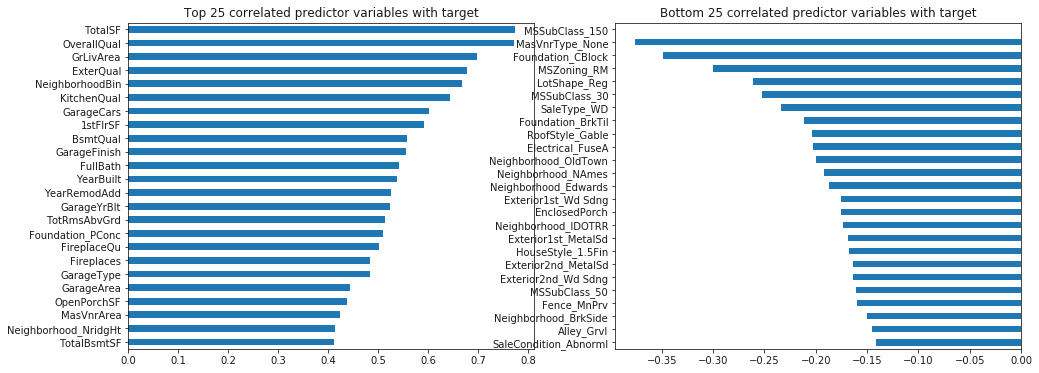

In [22]:
corr_df2 = pd.concat([all_data[:ntrain],sale_price], axis=1)

corr = corr_df2.corr()['SalePrice']

corr_rank = corr.sort_values(ascending=False)

corr_rank_high = corr_rank[1:25]
corr_rank_low = corr_rank[-25:]

plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
crH = corr_rank_high.sort_values(ascending=True)
crH.plot(kind='barh')
plt.title('Top 25 correlated predictor variables with target')

plt.subplot(1, 2, 2)
crL = corr_rank_low.sort_values(ascending=False)
crL.plot(kind='barh')
plt.title('Bottom 25 correlated predictor variables with target');

#### Setting up training and testing data

In [11]:
train = all_data[:ntrain]
test = all_data[ntrain:]

ntrain = train.shape[0]

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

y_train = np.log(1+np.array(sale_price))
train["SalePrice"] = np.log1p(sale_price)

train = train.drop('SalePrice', axis=1)

print('Size of training data: {}'.format(train.shape[0]))
print('Size of testing data: {}'.format(test.shape[0]))

Size of training data: 1452
Size of testing data: 1459


## Model training

In [12]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#### GridSearchCV

In [ ]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create train and test sets
#X_train = train
#y_train = ytrain
ytrain = y_train

X_train, X_test, y_train, y_test = train_test_split(train, ytrain, test_size=0.3, random_state=7)
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
enet_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
enet_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = enet_cv.predict(X_test)
r2 = enet_cv.score(X_test, y_test)
rmse = np.sqrt(np.abs(mean_squared_error(y_test, y_pred)))
print("Tuned ElasticNet l1 ratio: {}".format(enet_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet RMSE: {}".format(rmse))

In [18]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

def fit_model(X, y):
    """
    Tunes a decision tree regressor 
    model using GridSearchCV on the input data X 
    and target labels y and returns this optimal model.
    """

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Set up the parameters we wish to tune
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}

    # Make the GridSearchCV object
    reg = GridSearchCV(regressor, parameters)

    # Fit the learner to the data to obtain the optimal 
    # model with tuned parameters
    reg.fit(X, y)

    # Return the optimal model
    return reg.best_estimator_

# Test fit_model on entire dataset
try:
    reg = fit_model(np.array(train), np.array(ytrain))
    print("Successfully fit a model!")
except:
    print("Something went wrong with fitting a model.")

Successfully fit a model!


In [41]:
#reg_pred = reg.predict(y_test)
#reg_pred = np.expm1(reg_pred)
#predictions = pd.DataFrame( {'SalePrice_reg' : reg_pred })
#rmse = np.sqrt(np.abs(mean_squared_error(y_test, reg_pred)))
#print("Tuned DecisionRegressorTree: {}".format(rmse))

bayes opt: https://github.com/fmfn/BayesianOptimization/blob/master/examples/xgboost_example.py

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from bayes_opt import BayesianOptimization
from tqdm import tqdm
__author__ = "Vladimir Iglovikov"

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha,
                lambd,
                n_est):

    params['min_child_weight'] = int(min_child_weight)
    params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['lambda'] = max(lambd, 0)
    params['n_estimators'] = max(n_est,1)

    cv_result = xgb.cv(params, xgtrain, num_boost_round=num_rounds, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(50)])

    return -cv_result['test-rmse-mean'].values[-1]


def prepare_data():
    #train = pd.read_csv('/Users/mattjohnson/Desktop/Python 2018/kaggleHousing/train.csv')
    #categorical_columns = train.select_dtypes(include=['object']).columns
    
    y = ytrain
    
    X = train
    xgtrain = xgb.DMatrix(X, label=y)

    return xgtrain


if __name__ == '__main__':
    xgtrain = prepare_data()

    num_rounds = 3000
    random_state = 2018
    num_iter = 25
    init_points = 5
    params = {
        'silent': 1,
        'eval_metric': 'rmse', #'rmse'
        'verbose_eval': True,
        'seed': random_state
    }

    xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.1, 1),
                                                'max_depth':(1,10),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10),
                                                'alpha': (0, 10),
                                                'lambd': (0, 1),
                                                'n_est': (2000,3500)
                                                })

    xgbBO.maximize(init_points=init_points, n_iter=num_iter)


 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample
 ---|---|---
    20 | 01m18s |   -0.08350 |    0.0700 |             0.2223 |    0.0450 |      8.6302 |             1.0996 |      0.9356  <br>
    
    
Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |     lambd |   max_depth |   min_child_weight |   subsample  
    ---|---|---
     13 | 01m20s |   -0.08403 |    0.1861 |             0.4251 |    0.0479 |    0.7705 |      9.7308 |             1.8260 |      0.9232 
     
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |     lambd |   max_depth |   min_child_weight |     n_est |   subsample 
     ---|---|---
28 | 00m29s |   -0.12459 |    0.0000 |             1.0000 |    0.0000 |    1.0000 |      1.0000 |             1.0000 | 2938.0171 |      1.0000 
28 | 00m38s |   -0.08397 |    0.3993 |             0.2582 |    0.0117 |    0.2588 |      9.1408 |            18.7619 | 2194.0463 |      0.9853 
21 | 00m22s |   -0.12826 |    0.0000 |             0.6490 |    0.0000 |    0.0500 |      1.0000 |            20.0000 | 2088.5577 |      1.0000 
 25 | 00m16s |   -0.12726 |    0.0000 |             1.0000 |    0.0000 |    0.8516 |      1.0000 |             9.9824 | 3322.4719 |      1.0000 
 26 | 00m12s |   -0.12778 |    0.5134 |             0.1226 |    0.0069 |    0.2482 |      1.0802 |            19.5177 | 2774.6959 |      0.7626 

In [44]:
def averagingModels(X, train, labels, models=[]):
    for model in models:
        model.fit(train, labels)
    predictions = np.column_stack([
        model.predict(X) for model in models
    ])
    return np.mean(predictions, axis=1)

In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=1.000, gamma=0.000, 
                             learning_rate=0.05, max_depth=1, 
                             min_child_weight=9.9824, n_estimators=3323,
                             reg_alpha=0.000, reg_lambda=0.8516,
                             subsample=1.000, silent=1,
                             random_state =7, nthread = -1)

In [48]:
model_xgb.fit(train, ytrain)

scores_xgb = cross_val_score(model_xgb, train, ytrain, cv=10)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Accuracy: 0.8972 (+/- 0.0421)


In [52]:
model_xgb2 = xgb.XGBRegressor(colsample_bytree=0.1226, gamma=0.0069, 
                             learning_rate=0.05, max_depth=2, 
                             min_child_weight=19.5177, n_estimators=2775,
                             reg_alpha=0.5134, reg_lambda=0.2482,
                             subsample=0.7626, silent=1,
                             random_state =2018, nthread = -1)

In [53]:
model_xgb2.fit(train, ytrain)

scores_xgb2 = cross_val_score(model_xgb2, train, ytrain, cv=10)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_xgb2.mean(), scores_xgb2.std() * 2))

Accuracy: 0.9055 (+/- 0.0315)


In [55]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =2018)

In [56]:
GBoost.fit(train, ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=2018, subsample=1.0, verbose=0,
             warm_start=False)

In [57]:
scores_GB = cross_val_score(GBoost, train, ytrain, cv=5)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_GB.mean(), scores_GB.std() * 2))

Accuracy: 0.9019 (+/- 0.0190)


In [58]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [59]:
lasso.fit(train, ytrain)

scores_lasso = cross_val_score(lasso, train, ytrain, cv=10)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

Accuracy: 0.8976 (+/- 0.0687)


In [61]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [62]:
scores_ENet = cross_val_score(ENet, train, ytrain, cv=10)

print("Accuracy: %0.4f (+/- %0.f)" % (scores_ENet.mean(), scores_ENet.std() * 2))

Accuracy: 0.8975 (+/- 0)


In [63]:
y_train = np.log(1+np.array(sale_price))

final_pred_y = averagingModels(test, train, y_train, [model_xgb2,lasso,ENet, GBoost])
y_test_exp = np.expm1(final_pred_y)

In [73]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_test_exp
sub.to_csv('MJ_submission_july15.csv',index=False)
# 0.12116

In [74]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [76]:
KRR.fit(train, ytrain)

scores_KRR = cross_val_score(KRR, train, ytrain, cv=5)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_KRR.mean(), scores_KRR.std() * 2))

Accuracy: 0.8958 (+/- 0.0282)


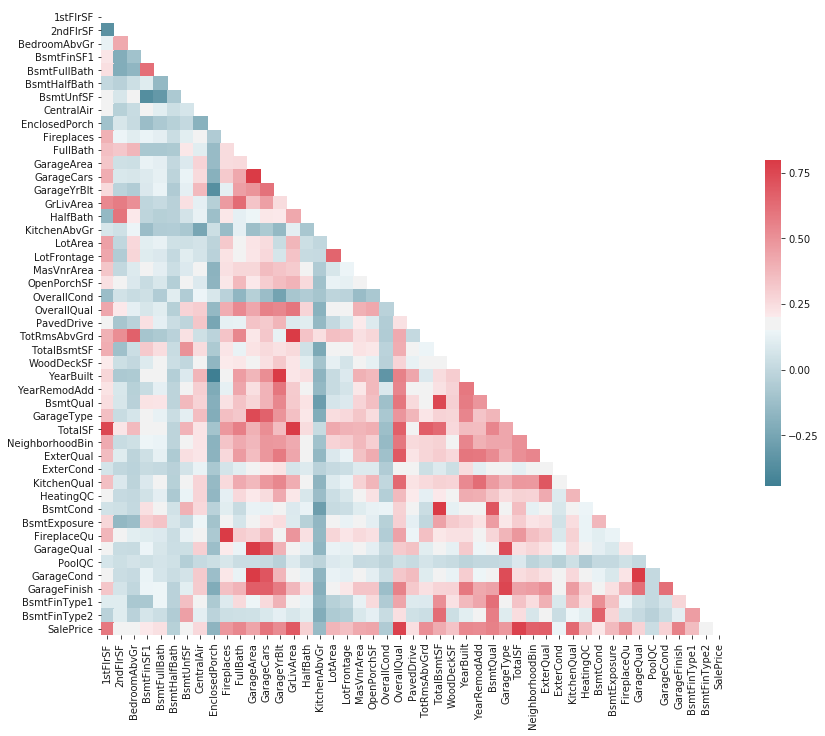

In [98]:
numeric_data = y_df.select_dtypes(include=['float64']) # num_df (1460, 38)
#numeric_data = numeric_data.drop(['Id'], axis=1)
numeric_data = pd.concat([numeric_data, sale_price], axis=1)
numeric_data_corr = numeric_data.corr()
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.zeros_like(numeric_data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))
#
# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#
# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(numeric_data_corr, mask=mask, cmap=cmap,vmax=.8,
            square=True, cbar_kws={"shrink": .5}, ax=ax)